In [1]:
import xlrd
import numpy as np 
import pandas as pd 
import geopandas as gpd 
import matplotlib.pyplot as plt 

%matplotlib inline

,t,arr,shelter,move,avg_fdist,neg_fdist,out_evac_zone_cnts,out_evac_buffer_cnts,shelter_tot
176,17600,15049,4191,0,0,874,0,0,515337
177,17700,15049,4191,0,0,874,0,0,519528
178,17800,15049,4191,0,0,874,0,0,523719
179,17900,15049,4191,0,0,874,0,0,527910
180,18000,15049,4191,0,0,874,0,0,532101


,t,arr,shelter,move,avg_fdist,neg_fdist,out_evac_zone_cnts,out_evac_buffer_cnts,shelter_tot
176,17600,19818,20,6,0,60,0,0,3160
177,17700,19845,20,3,0,27,0,0,3180
178,17800,19868,20,5,0,0,0,0,3200
179,17900,19902,20,1,0,0,0,0,3220
180,18000,19931,20,3,0,0,0,0,3240


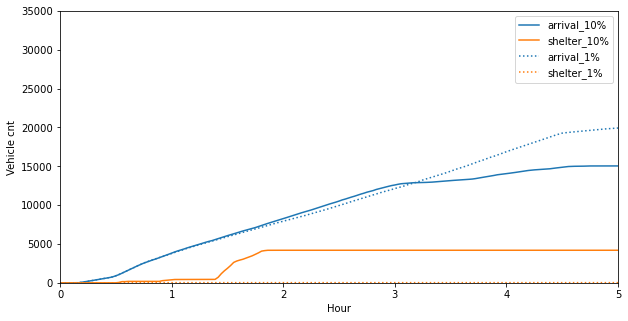

In [15]:
scen_nm = 'full_dict_c0.1_d1'
t_stats = pd.read_csv('t_stats/t_stats_{}.csv'.format(scen_nm))
t_stats['shelter_tot'] = t_stats['shelter'].cumsum()
display(t_stats.tail())

scen_nm = 'full_dict_c0.01_d1'
t_stats_2 = pd.read_csv('t_stats/t_stats_{}.csv'.format(scen_nm))
t_stats_2['shelter_tot'] = t_stats_2['shelter'].cumsum()
display(t_stats_2.tail())

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_stats['t']/3600, t_stats['arr'], label='arrival_10%')
ax.plot(t_stats['t']/3600, t_stats['shelter'], label='shelter_10%')
# ax.plot(t_stats['t']/3600, t_stats['out_evac_buffer_cnts'], label='out_10%')

ax.plot(t_stats_2['t']/3600, t_stats_2['arr'], ls=':', c=u'#1f77b4', label='arrival_1%')
ax.plot(t_stats_2['t']/3600, t_stats_2['shelter'], ls=':', c=u'#ff7f0e', label='shelter_1%')
# ax.plot(t_stats_2['t']/3600, t_stats_2['out_evac_buffer_cnts'], ls=':', c=u'#2ca02c', label='out_1%')

ax.set_xlim([0,5])
ax.set_ylim([0,35000])
plt.xlabel('Hour')
plt.ylabel('Vehicle cnt')
plt.legend()
plt.show()

In [24]:
node_stats = pd.read_csv('node_stats/node_agent_cnts_real_full_c0.01_t3600.csv')
print(node_stats['status'].unique(), node_stats['arr_status'].unique())
display(node_stats.groupby(['status', 'arr_status']).size())
node_stats.head()

['loaded'] ['chance' 'flow']


status  arr_status
loaded  chance        428
        flow          308
dtype: int64

,node_id,status,arr_status,cnt
0,7.0,loaded,chance,5
1,106.0,loaded,flow,15
2,162.0,loaded,chance,13
3,164.0,loaded,chance,8
4,167.0,loaded,chance,15


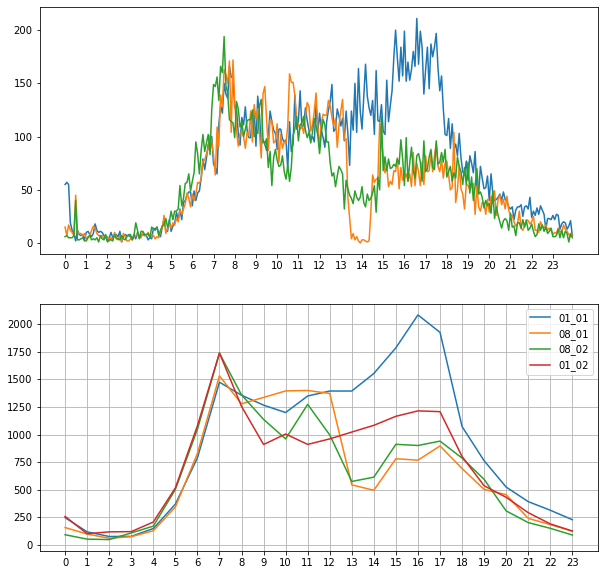

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
for date_dir in ['01_01', '08_01', '08_02']:
    validation = pd.read_excel('../validation/paradise_11_{}/pems_flow_11_{}.xlsx'.format(date_dir, date_dir))
    if date_dir[0:2] =='01': ref_date='2018-11-01T00:00:00'
    if date_dir[0:2] =='08': ref_date='2018-11-08T00:00:00'
    validation['time'] = validation['5 Minutes'] - np.datetime64(ref_date)
    validation['time'] = validation['time'].dt.total_seconds()
    # display(validation.head())
    
    ax[0].plot(validation['time']/3600, validation['Flow (Veh/5 Minutes)'], label=date_dir)
    ax[0].set_xticks(list(range(24)))
    
    validation_hr = validation.copy()
    validation_hr['hour'] = validation_hr['time']//3600
    validation_hr = validation_hr.groupby('hour').agg({'Flow (Veh/5 Minutes)': np.sum}).reset_index()

    ax[1].plot(validation_hr['hour'], validation_hr['Flow (Veh/5 Minutes)'], label=date_dir)
    ax[1].set_xticks(list(range(24)))
    
for date_dir in ['01_02']:
    validation = pd.read_excel('../validation/paradise_11_{}/pems_flow_11_{}.xlsx'.format(date_dir, date_dir))
    if date_dir[0:2] =='01': ref_date='2018-11-01T00:00:00'
    if date_dir[0:2] =='08': ref_date='2018-11-08T00:00:00'
    validation['hour'] = validation['Hour'] - np.datetime64(ref_date)
    validation['hour'] = validation['hour'].dt.total_seconds()/3600
    # display(validation.head())

    validation_hr = validation.copy()
    ax[1].plot(validation_hr['hour'], validation_hr['Flow (Veh/Hour)'], label=date_dir)
    ax[1].set_xticks(list(range(24)))
    plt.legend()
    plt.grid()
    plt.show()

,hour,Speed (mph)
0,0.0,66.291667
1,1.0,65.758333
2,2.0,65.841667
3,3.0,65.683333
4,4.0,66.875000
5,5.0,66.741667
6,6.0,67.175000
7,7.0,63.925000
8,8.0,60.708333
9,9.0,57.025000


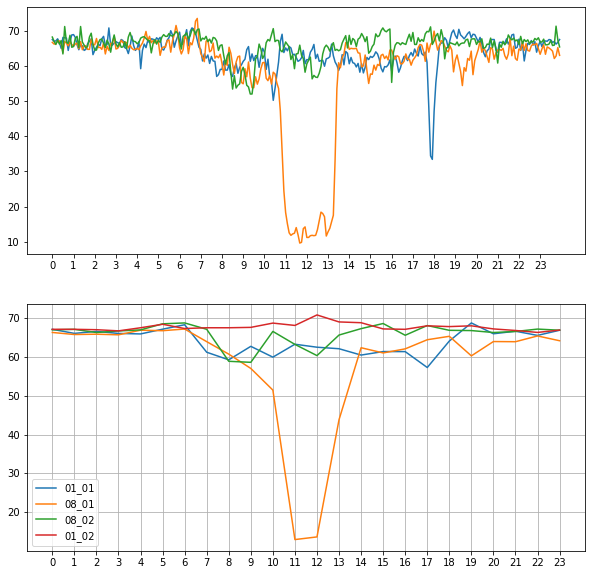

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
for date_dir in ['01_01', '08_01', '08_02']:
    validation = pd.read_excel('../validation/paradise_11_{}/pems_speed_11_{}.xlsx'.format(date_dir, date_dir))
    if date_dir[0:2] =='01': ref_date='2018-11-01T00:00:00'
    if date_dir[0:2] =='08': ref_date='2018-11-08T00:00:00'
    validation['time'] = validation['5 Minutes'] - np.datetime64(ref_date)
    validation['time'] = validation['time'].dt.total_seconds()
    # display(validation.head())
    
    ax[0].plot(validation['time']/3600, validation['Speed (mph)'], label=date_dir)
    ax[0].set_xticks(list(range(24)))
    
    validation_hr = validation.copy()
    validation_hr['hour'] = validation_hr['time']//3600
    validation_hr = validation_hr.groupby('hour').agg({'Speed (mph)': np.mean}).reset_index()
    if date_dir=='08_01':
        display(validation_hr)

    ax[1].plot(validation_hr['hour'], validation_hr['Speed (mph)'], label=date_dir)
    ax[1].set_xticks(list(range(24)))
    
for date_dir in ['01_02']:
    validation = pd.read_excel('../validation/paradise_11_{}/pems_speed_11_{}.xlsx'.format(date_dir, date_dir))
    if date_dir[0:2] =='01': ref_date='2018-11-01T00:00:00'
    if date_dir[0:2] =='08': ref_date='2018-11-08T00:00:00'
    validation['hour'] = validation['Hour'] - np.datetime64(ref_date)
    validation['hour'] = validation['hour'].dt.total_seconds()/3600
    # display(validation.head())

    validation_hr = validation.copy()
    ax[1].plot(validation_hr['hour'], validation_hr['Speed (mph)'], label=date_dir)
    ax[1].set_xticks(list(range(24)))
    plt.legend()
    plt.grid()
    plt.show()

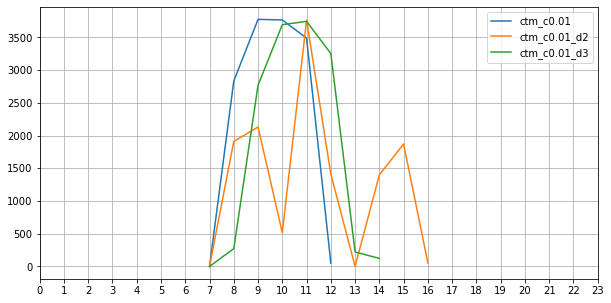

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
for scen_nm in ['ctm_c0.01', 'ctm_c0.01_d2', 'ctm_c0.01_d3']:
    transfer = pd.read_csv('transfer_stats/transfer_stats_{}.csv'.format(scen_nm))
    transfer['hour'] = transfer['t']//3600+8
    transfer['hourly_flow'] = transfer['29-33']-transfer['29-33'].shift(1)
    # display(transfer.head())
    transfer_hour = transfer.groupby('hour').agg({'hourly_flow': np.sum}).reset_index()
    
    ax.plot([7]+transfer_hour['hour'].values.tolist(), [0]+transfer_hour['hourly_flow'].values.tolist(), label=scen_nm)
    ax.set_xticks(list(range(24)))
    plt.legend()
    plt.grid()